In [65]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import RandomRotation,RandomZoom,RandomTranslation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [67]:
from sklearn.model_selection import train_test_split

y = train_df["label"].values
X = train_df.drop(columns=["label"]).values

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [68]:
X_train = X_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
X_test  = X_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

df_test = test_df.values
df_test = df_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

In [69]:
data_augmentation = Sequential([
    RandomRotation(0.15),  # ±27°
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])

In [76]:
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,322 (1.38 MB)

 Trainable params: 361,322 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,         # para de treinar após 3 épocas sem melhora
    restore_best_weights=True
)

In [78]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [79]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 86s 201ms/step - accuracy: 0.6465 - loss: 1.0377 - val_accuracy: 0.9500 - val_loss: 0.1651
Epoch 2/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 140s 197ms/step - accuracy: 0.9349 - loss: 0.2085 - val_accuracy: 0.9769 - val_loss: 0.0757
Epoch 3/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 84s 202ms/step - accuracy: 0.9546 - loss: 0.1467 - val_accuracy: 0.9830 - val_loss: 0.0627
Epoch 4/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 81s 196ms/step - accuracy: 0.9642 - loss: 0.1178 - val_accuracy: 0.9796 - val_loss: 0.0619
Epoch 5/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step - accuracy: 0.9696 - loss: 0.1004 - val_accuracy: 0.9765 - val_loss: 0.0849
Epoch 6/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 146s 211ms/step - accuracy: 0.9714 - loss: 0.0941 - val_accuracy: 0.9806 - val_loss: 0.0714
Epoch 7/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 135s 195ms/step - accuracy: 0.9744 - loss: 0.0859 - val_accuracy: 0.9884 - val_loss: 0.0407
Epoch 8/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.9780 - loss

In [80]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Acurácia no teste:", acc)

394/394 - 10s - 24ms/step - accuracy: 0.9851 - loss: 0.0482
Acurácia no teste: 0.9850793480873108


394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1200
           1       0.99      0.99      0.99      1389
           2       0.99      0.98      0.98      1294
           3       1.00      0.98      0.99      1355
           4       0.99      0.99      0.99      1222
           5       0.99      0.98      0.98      1085
           6       0.99      0.98      0.99      1256
           7       0.96      0.99      0.97      1359
           8       0.99      0.98      0.99      1209
           9       0.98      0.99      0.98      1231

    accuracy                           0.99     12600
   macro avg       0.99      0.99      0.99     12600
weighted avg       0.99      0.99      0.99     12600



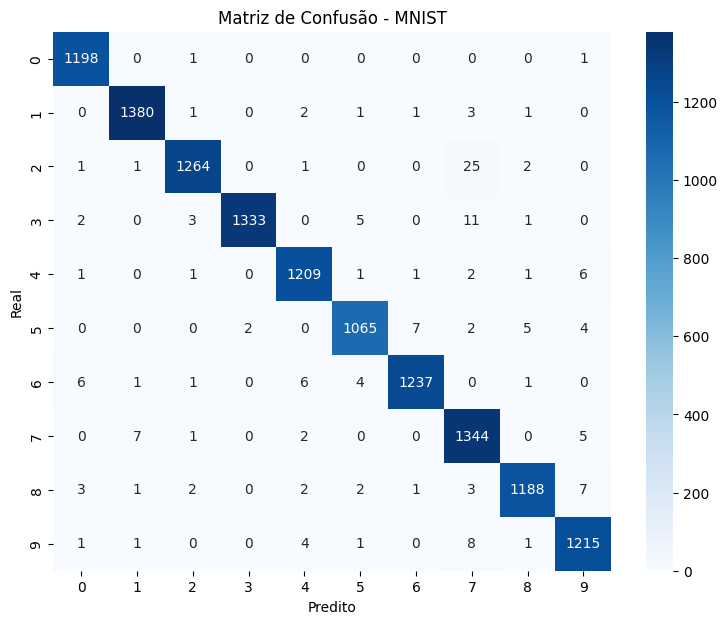

In [63]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# ---------------------------------------------------------
# 10. Classification Report
# ---------------------------------------------------------
print("\nCLASSIFICATION REPORT:\n")
print(classification_report(y_test, y_pred_classes))

# ---------------------------------------------------------
# 11. Matriz de confusão
# ---------------------------------------------------------
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - MNIST")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [42]:
y_pred = model.predict(df_test)


875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step


In [44]:
y_pred.shape

(28000, 10)

In [45]:
df_submission = pd.DataFrame({'ImageId': range(1, len(y_pred) + 1), 'Label': np.argmax(y_pred, axis=1)})
df_submission.to_csv('submission.csv',index=False)

In [46]:
df = pd.read_csv("submission.csv")
df_test.shape

(28000, 28, 28, 1)